In [3]:
import os
from subprocess import run
res = run(["git", "rev-parse", "--show-toplevel"], capture_output=True)
root_dir = res.stdout.decode().strip()
os.chdir(root_dir)

In [4]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy.constants

import simdata

%reload_ext autoreload
%autoreload 2
from importlib import reload
from pprint import pprint
from functools import lru_cache

from simdata_vorticity import provide_simulation_data, velocity_cartesian_simdata, velocity_polar_simdata, roll_data
from src.vortector.vortector import Vortector
from src.vortector.visualize import show_fit_overview_2D

%matplotlib widget

In [47]:
@lru_cache
def calc_cartesian_velocity(simid, Noutput):
    data = simdata.SData(simid)
    rv = velocity_cartesian_simdata(data, Noutput)
    return rv

@lru_cache
def get_polar_velocity(simid, Noutput):
    data = simdata.SData(simid)
    rv = velocity_polar_simdata(data, Noutput)
    return rv


def select_radial_range(nlow, nhigh, *args):
    rv = (x[nlow:nhigh] for x in args)
    return rv

In [193]:
# nice vortex
# simid = "139400f3"
# Noutput = 101

# growing planet, band
simid = "06f2cc46"
# Noutput = 47
Noutput = 100

# beta1 alpha-4 fargo 8cps
# simid = "9428f411"
# Noutput = 25

Rlims = [5.2, 10]

data = simdata.SData(simid)

R, Phi, A, vortensity, vorticity, Rho, Rho_background = provide_simulation_data(simid, Noutput, skip_cache=False)
nl = np.argmin(np.abs(R[:,0]-Rlims[0]))
nr = np.argmin(np.abs(R[:,0]-Rlims[1]))
R, Phi, A, vortensity, vorticity, Rho, Rho_background = select_radial_range(nl, nr, R, Phi, A, vortensity, vorticity, Rho, Rho_background)
X, Y, Vx, Vy = select_radial_range(nl, nr, *calc_cartesian_velocity(simid, Noutput))
Vr, Vphi, Vk = select_radial_range(nl, nr, *get_polar_velocity(simid, Noutput))


CPU times: user 213 ms, sys: 60.2 ms, total: 273 ms
Wall time: 123 ms


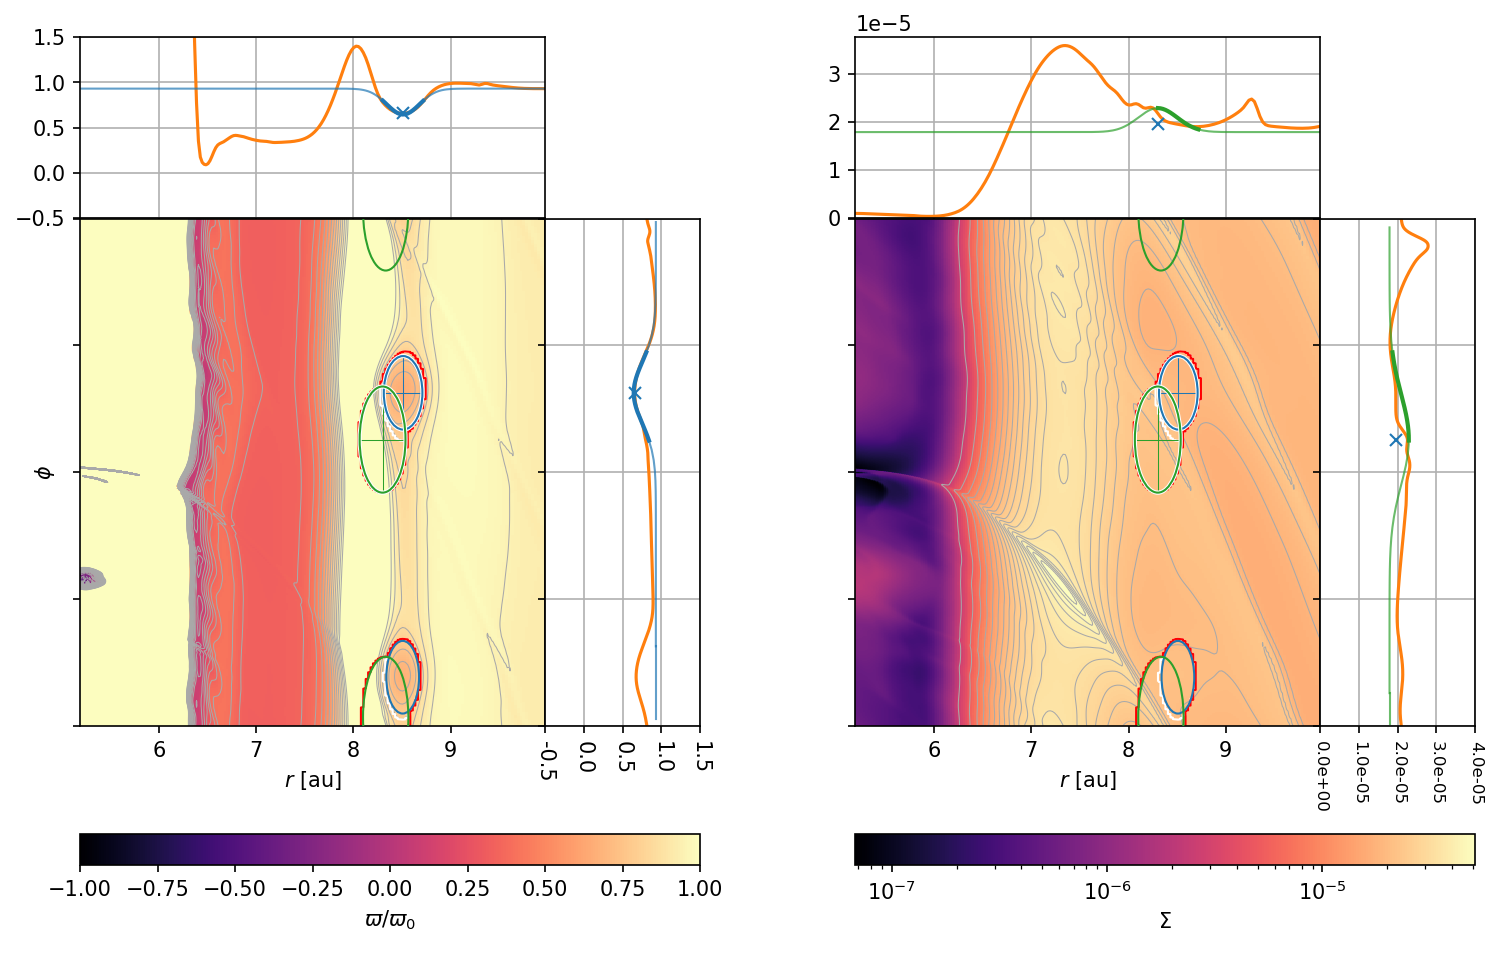

In [194]:
%matplotlib inline
vd = Vortector(R, Phi, A, vortensity, Rho)
%time vortices = vd.detect(include_mask=True, keep_internals=True)

show_fit_overview_2D(vd)

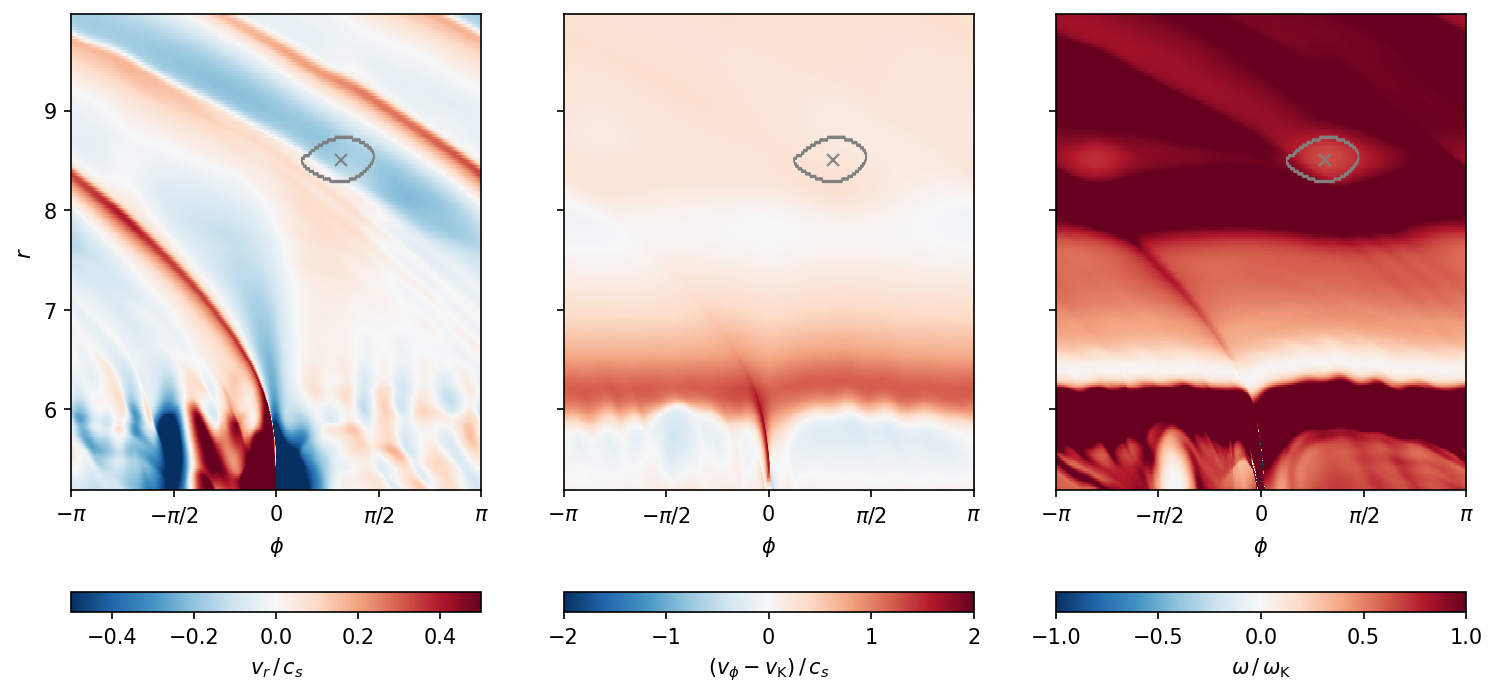

In [226]:
%matplotlib inline
fig, axes = plt.subplots(1,3,sharey="all", dpi=150, figsize=(12,6))

cbar_orientation = "horizontal"
# cbar_orientation = "vertical"

ax = axes[0]
vscale = 0.5
vmin, vmax = -vscale, vscale
Cs = Vk*0.05
im = ax.pcolormesh(Phi, R, Vr/Cs, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$v_r \,/\, c_s$")

ax = axes[1]
vscale = 2
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, (Vphi-Vk)/Cs, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$(v_\phi - v_\mathrm{K}) \,/\, c_s$")

ax = axes[2]
vscale = 1
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, vorticity, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label("$\omega\,/\,\omega_\mathrm{K}$")

vort = vd.vortices[0]
for ax in axes:
    ax.contour(Phi, R, vd.get_mask(vort, region="contour"), colors="Grey", linewidths=0.5)
    r, phi = vort["contour"]["stats"]["vortensity_min_pos"]
    ax.plot([phi], [r], "x", color="Grey")

axes[0].set_ylabel("$r$")
for ax in axes:
    ax.set_xticks(np.array([-1,-0.5,0,0.5,1])*np.pi)
    ax.set_xticklabels(["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
    ax.set_xlabel("$\phi$")


In [218]:
%matplotlib widget
fig, ax = plt.subplots(dpi=150)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [219]:
Nsub = 10

def zoomed_quiver(ax, R, Phi, Vr, Vphi, sub=(1,1), bb=[[0,-1],[0,-1]]):
    X = R[bb[0][0]:bb[0][1]:sub[0], bb[1][0]:bb[1][1]:sub[1]]
    Y = Phi[bb[0][0]:bb[0][1]:sub[0], bb[1][0]:bb[1][1]:sub[1]]
    U = Vr[bb[0][0]:bb[0][1]:sub[0], bb[1][0]:bb[1][1]:sub[1]]
    V = Vphi[bb[0][0]:bb[0][1]:sub[0], bb[1][0]:bb[1][1]:sub[1]]
    U = np.sign(U)*np.log( np.abs(U)/np.min(np.abs(U)) )
    V = np.sign(V)*np.log( np.abs(V)/np.min(np.abs(V)) )
    ax.quiver(X, Y, U, V)

bb = vd.get_bbox(vort)
bbox_inds = [[bb["xlow"]["inds"][0], bb["xhigh"]["inds"][0]],
             [bb["ylow"]["inds"][1], bb["yhigh"]["inds"][1]]]
    
zoomed_quiver(
    ax, 
    Phi, R,
    ((Vphi - Vk)/Cs).decompose().value,
    (Vr/Cs).decompose().value,
#     bb=bbox_inds,
    sub=(3,30)
)

ax.contour(Phi, R, vd.get_mask(vort, region="contour"), colors="C3", linewidths=0.5)

ax.set_xlabel("$\phi$")
ax.set_ylabel("$r$")

ax.set_title("Velocities $v_r\,/\,v_\mathrm{K}$ and $(v_\phi - v_\mathrm{K})\,/\,c_s$ , log length")

Text(0.5, 1.0, 'Velocities $v_r\\,/\\,v_\\mathrm{K}$ and $(v_\\phi - v_\\mathrm{K})\\,/\\,c_s$ , log length')

array([-1,  1])

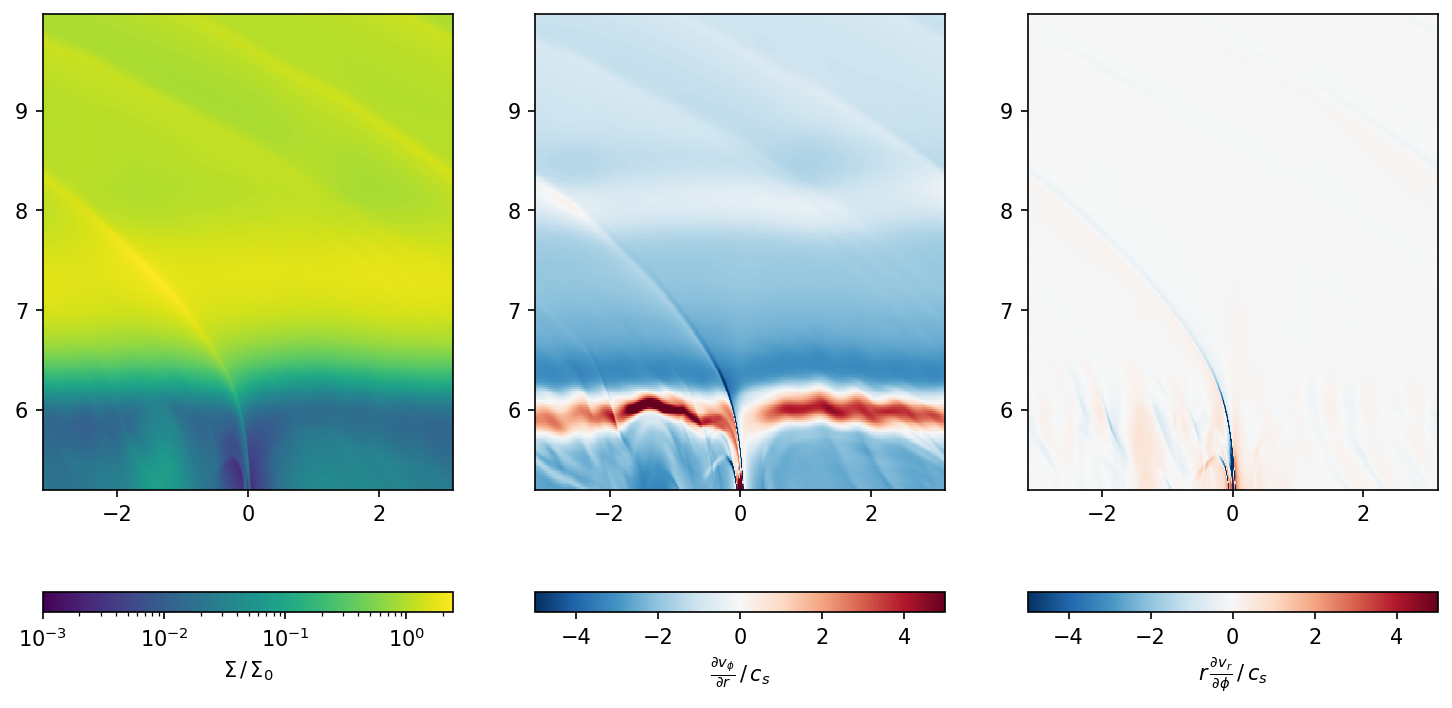

In [306]:
%matplotlib inline
from matplotlib.colors import LogNorm
dvphi_dr = np.gradient(Vphi, R[:,0], axis=0)
dvr_dphi = np.gradient(Vr, Phi[0], axis=1)

fig, axes = plt.subplots(1,3,dpi=150, figsize=(12,6))

ax = axes[0]
vmin, vmax = 1e-3, None
im = ax.pcolormesh(Phi, R, Rho/Rho_background, cmap="viridis", norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$\Sigma \,/\, \Sigma_0$")

ax = axes[1]
vscale = 5
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dvphi_dr/Cs, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$\frac{\partial v_\phi}{\partial r} \,/\, c_s$")

ax = axes[2]
vscale = 5
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, dvr_dphi/Cs/R, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation)
cbar.set_label(r"$r \, \frac{\partial v_r}{\partial \phi}  \,/\, c_s$")

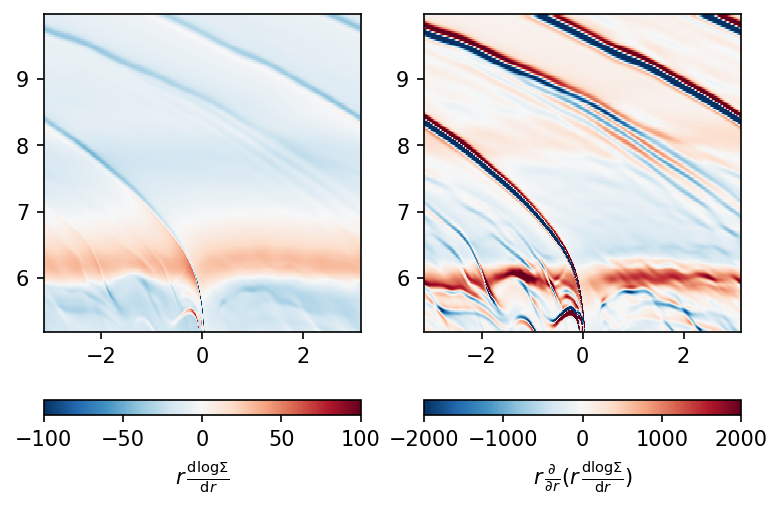

In [303]:
%matplotlib inline
fig, axes = plt.subplots(1,2,dpi=150)
s = np.gradient(R*np.log(Rho), R[:,0], axis=0)
ds_dr = np.gradient(s, R[:,0], axis=0)

ax = axes[0]
vscale = 100
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, s, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$ r \,\frac{\mathrm{d log} \Sigma}{\mathrm{d}r}$")

ax = axes[1]
vscale = 2000
vmin, vmax = -vscale, vscale
im = ax.pcolormesh(Phi, R, R*ds_dr, cmap="RdBu_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
cbar.set_label(r"$r\, \frac{\partial}{\partial r}  (r \,\frac{\mathrm{d log} \Sigma}{\mathrm{d}r})$")

Text(0, 0.5, '$r\\, \\frac{\\partial}{\\partial r}  (r \\,\\frac{\\mathrm{d log} \\Sigma}{\\mathrm{d}r})$')

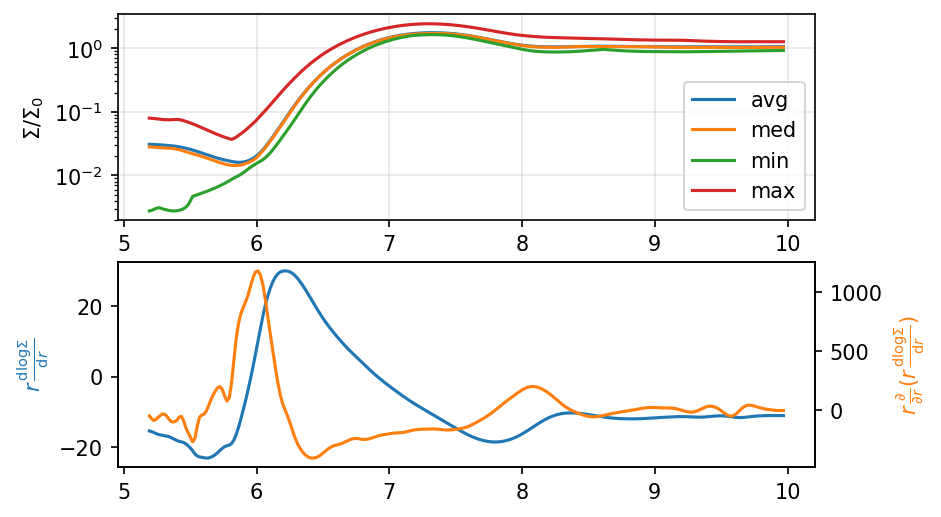

In [310]:
%matplotlib inline
fig, axes = plt.subplots(2,1,dpi=150)

ax = axes[0]
Z = Rho/Rho_background
ax.plot(R[:,0], np.average(Z, axis=1), label="avg")
ax.plot(R[:,0], np.median(Z, axis=1), label="med")
ax.plot(R[:,0], np.min(Z, axis=1), label="min")
ax.plot(R[:,0], np.max(Z, axis=1), label="max")
ax.set_yscale("log")
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlabel("$r$")
ax.set_ylabel("$\Sigma/\Sigma_0$")

ax = axes[1]
ax.plot(R[:,0], np.average(s, axis=1), color="C0")
ax.set_ylabel(r"$ r \,\frac{\mathrm{d log} \Sigma}{\mathrm{d}r}$", color="C0")
ax2 = ax.twinx()
ax2.plot(R[:,0], np.average(R*ds_dr, axis=1), color="C1")
ax2.set_ylabel(r"$r\, \frac{\partial}{\partial r}  (r \,\frac{\mathrm{d log} \Sigma}{\mathrm{d}r})$", color="C1")

In [293]:
0.05**2*40*5

0.5000000000000001